# Investigation of Trip Data from Bay Area Bike Share Published Data

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
from scipy import stats
import scipy
import math
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime

import seaborn as sns
# sns.set()
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

TITLE_FONT_SIZE = 25
LABEL_FONT_SIZE = 15
TICK_FONT_SIZE  = 10

# Load Trip Data

In [3]:
print('[%s] Loading Trip Data Data...' % datetime.datetime.now().time())

trips_df = pd.DataFrame()
trip_data_file = '../clean_data/bayareabikeshare/trip_data_extended_cleaned.csv'

# Chunk Settings
chunks = []
chunk_counter = 1
chunksize = 10000
num_chunks = math.ceil(sum(1 for row in open(trip_data_file, 'r'))/chunksize)

# import file in chunks
for chunk in pd.read_csv(trip_data_file, chunksize=chunksize, iterator=True, index_col=0, parse_dates=['start_date', 'end_date']):
    
    # append chunk to chunks list
    chunks.append(chunk)

    if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
        print('\t\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
    chunk_counter += 1

trips_df = pd.concat(chunks)
trips_df.user_type = trips_df.user_type.astype('category')

print('[%s] Complete!' % datetime.datetime.now().time())


[17:03:19.149372] Loading Trip Data Data...
		[17:03:19.965075] finished chunk 1 of 100
		[17:03:20.717719] finished chunk 10 of 100
		[17:03:21.524567] finished chunk 20 of 100
		[17:03:22.294284] finished chunk 30 of 100
		[17:03:23.075682] finished chunk 40 of 100
		[17:03:23.866312] finished chunk 50 of 100
		[17:03:24.633267] finished chunk 60 of 100
		[17:03:25.455689] finished chunk 70 of 100
		[17:03:26.251198] finished chunk 80 of 100
		[17:03:27.043364] finished chunk 90 of 100
		[17:03:27.865432] finished chunk 100 of 100
[17:03:28.633887] Complete!


In [4]:
trips_df.head(5)

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


In [5]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998523 entries, 0 to 998522
Data columns (total 23 columns):
trip_id               998523 non-null int64
duration              998523 non-null int64
start_date            998523 non-null datetime64[ns]
start_station_name    998523 non-null object
start_terminal        998523 non-null int64
end_date              998523 non-null datetime64[ns]
end_station_name      998523 non-null object
end_terminal          998523 non-null int64
bike_id               998523 non-null int64
user_type             998523 non-null category
user_zip              998523 non-null int64
duration_minutes      998523 non-null float64
start_zip             998523 non-null int64
end_zip               998523 non-null int64
max_temp              998458 non-null float64
mean_temp             998458 non-null float64
min_temp              998458 non-null float64
max_wind              998518 non-null float64
mean_wind             998518 non-null float64
max_gust          

## Utility Functions

In [6]:
def zip_to_landmark(zip_code):
    ''' Return zipcode for given landmark'''
    if zip_code == 94107:
        return 'San Francisco'
    if zip_code == 94063:
        return 'Redwood City'
    if zip_code == 94301:
        return 'Palo Alto'
    if zip_code == 94041:
        return 'Mountain View'
    if zip_code == 95113:
        return 'San Jose'
    return False

In [7]:
day_labels = ['MON','TUE','WED','THU','FRI','SAT','SUN']
day_labels_full = ['MONDAY','TUESDAY','WEDNESDAY','THURSDAY','FRIDAY','SATURDAY','SUNDAY']
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

# Analysis 1 - Usage by Region

<ul>
    <li>How many Trips are taken within each region?</li>
    <li>How many Trips are taken within each region by user type?</li>
    <li>How many Trips are taken that cross from one rgion to another?</li>
</ul>

In [8]:
ordered_zipcodes = [94107, 95113, 94041, 94301, 94063]

print('\t\t\t\t\t\t\t\tSubscriber\tSubscriber\tCustomer\tCustomer')
print('\t\tRegion\t\tTrip Count\tTrip Share\tTrip Count\tRegion Share\tTrip Count\tRegion Share')

# data for all trip
babs_label='Full Service Area'
babs_trip_count            = trips_df.trip_id.count()
babs_trip_count_subscriber = trips_df[trips_df.user_type == 'Subscriber'].trip_id.count()
babs_trip_share_subscriber = babs_trip_count_subscriber / trips_df.trip_id.count() * 100.
babs_trip_share_subscriber = '{:2.4f}'.format(babs_trip_share_subscriber).rjust(6)

babs_trip_count_customer   = trips_df[trips_df.user_type == 'Customer'].trip_id.count()
babs_trip_share_customer   = babs_trip_count_customer / trips_df.trip_id.count() * 100.
babs_trip_share_customer = '{:2.4f}'.format(babs_trip_share_customer).rjust(6)

print('%s\t\t%s\t%s\t%s\t%s\t%s\t%s' % (babs_label.rjust(20), 
                                        str(babs_trip_count).rjust(10), 
                                        str('100.0000').rjust(10), 
                                        str(babs_trip_count_subscriber).rjust(10), 
                                        str(babs_trip_share_subscriber).rjust(10), 
                                        str(babs_trip_count_customer).rjust(10), 
                                        str(babs_trip_share_customer).rjust(10)))


for zip_code in ordered_zipcodes:

        
    # subset All Days
    trips_in_zip            = trips_df[(trips_df.start_zip == zip_code) & (trips_df.end_zip == zip_code)]
    subscriber_trips_in_zip = trips_in_zip[trips_in_zip.user_type == 'subscriber'.title()]
    customer_trips_in_zip   = trips_in_zip[trips_in_zip.user_type == 'customer'.title()]
    
    # subset Weekend Only
    weekend_trips_in_zip            =     trips_in_zip[trips_in_zip.start_date.dt.dayofweek < 5]
    weekend_subscriber_trips_in_zip =     subscriber_trips_in_zip[subscriber_trips_in_zip.start_date.dt.dayofweek < 5]
    weekend_customer_trips_in_zip   =     customer_trips_in_zip[customer_trips_in_zip.start_date.dt.dayofweek < 5]
    
    # subset Weekdays Only
    weekday_trips_in_zip            =     trips_in_zip[trips_in_zip.start_date.dt.dayofweek >= 5]
    weekday_subscriber_trips_in_zip =     subscriber_trips_in_zip[subscriber_trips_in_zip.start_date.dt.dayofweek >= 5]
    weekday_customer_trips_in_zip   =     customer_trips_in_zip[customer_trips_in_zip.start_date.dt.dayofweek >= 5]
    
    # format All Days
    trips_in_zip_count = trips_in_zip.shape[0]

    trips_in_zip_share = trips_in_zip.shape[0] / trips_df.shape[0] * 100.
    trips_in_zip_share = '{:2.4f}'.format(trips_in_zip_share)
    
    subscriber_trips_in_zip_count = subscriber_trips_in_zip.shape[0]

    subscriber_trips_in_zip_share = subscriber_trips_in_zip.shape[0] / trips_in_zip.shape[0] * 100.
    subscriber_trips_in_zip_share = '{:2.4f}'.format(subscriber_trips_in_zip_share)
    
    customer_trips_in_zip_count = customer_trips_in_zip.shape[0]

    customer_trips_in_zip_share = customer_trips_in_zip.shape[0] / trips_in_zip.shape[0] * 100.
    customer_trips_in_zip_share = '{:2.4f}'.format(customer_trips_in_zip_share)
    
    
    print('%s\t\t%s\t%s\t%s\t%s\t%s\t%s' % (zip_to_landmark(zip_code).rjust(20), 
                                            str(trips_in_zip_count).rjust(10), 
                                            str(trips_in_zip_share).rjust(10), 
                                            str(subscriber_trips_in_zip_count).rjust(10), 
                                            str(subscriber_trips_in_zip_share).rjust(10), 
                                            str(customer_trips_in_zip_count).rjust(10), 
                                            str(customer_trips_in_zip_share).rjust(10)))
    
# cross region trips
cross_region_trips = trips_df[trips_df.start_zip != trips_df.end_zip]

cross_region_label='Cross Region'
cross_region_trip_count = cross_region_trips.trip_id.count()

cross_region_trip_share = cross_region_trips.shape[0] / trips_df.shape[0] * 100.
cross_region_trip_share = '{:2.4f}'.format(cross_region_trip_share)

cross_region_trip_count_subscriber = cross_region_trips[cross_region_trips.user_type == 'Subscriber'].trip_id.count()
cross_region_trip_share_subscriber = cross_region_trip_count_subscriber / cross_region_trips.trip_id.count() * 100.
cross_region_trip_share_subscriber = '{:2.4f}'.format(cross_region_trip_share_subscriber).rjust(6)

cross_region_trip_count_customer   = cross_region_trips[cross_region_trips.user_type == 'Customer'].trip_id.count()
cross_region_trip_share_customer   = cross_region_trip_count_customer / cross_region_trips.trip_id.count() * 100.
cross_region_trip_share_customer = '{:2.4f}'.format(cross_region_trip_share_customer).rjust(6)

print('%s\t\t%s\t%s\t%s\t%s\t%s\t%s' % (cross_region_label.rjust(20), 
                                        str(cross_region_trip_count).rjust(10), 
                                        str(cross_region_trip_share).rjust(10), 
                                        str(cross_region_trip_count_subscriber).rjust(10), 
                                        str(cross_region_trip_share_subscriber).rjust(10), 
                                        str(cross_region_trip_count_customer).rjust(10), 
                                        str(cross_region_trip_share_customer).rjust(10)))

								Subscriber	Subscriber	Customer	Customer
		Region		Trip Count	Trip Share	Trip Count	Region Share	Trip Count	Region Share
   Full Service Area		    998523	  100.0000	    879044	   88.0344	    119479	   11.9656
       San Francisco		    902635	   90.3970	    797541	   88.3570	    105094	   11.6430
            San Jose		     51012	    5.1087	     43978	   86.2111	      7034	   13.7889
       Mountain View		     29005	    2.9048	     25134	   86.6540	      3871	   13.3460
           Palo Alto		      7591	    0.7602	      5530	   72.8494	      2061	   27.1506
        Redwood City		      6822	    0.6832	      5976	   87.5989	       846	   12.4011
        Cross Region		      1458	    0.1460	       885	   60.6996	       573	   39.3004


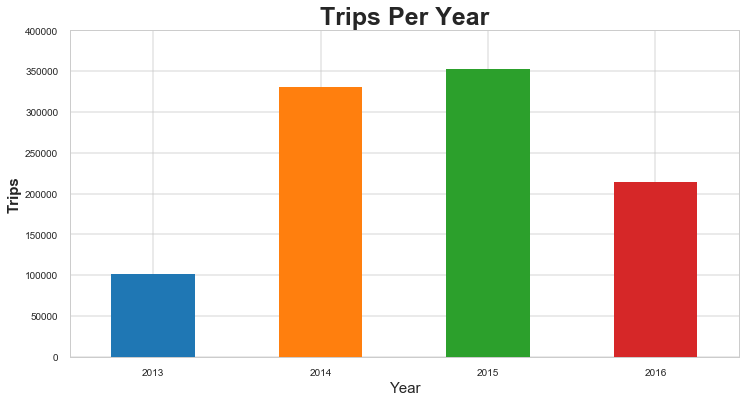

In [9]:
# Trips per year

trips_per_year_df = pd.DataFrame()

trips_per_year_df['trips'] = trips_df.groupby(trips_df.start_date.dt.year)['trip_id'].count().transpose()
trips_per_year_df.reset_index(inplace=True)
trips_per_year_df.rename(columns={'start_date':'year'}, inplace=True)

months_per_year = pd.Series([5, 12, 12, 8])
trips_per_year_df['months_per_year'] = months_per_year
trips_per_year_df['trips_adj'] = trips_per_year_df['trips'] * (12/ trips_per_year_df['months_per_year'])

ax = trips_per_year_df['trips'].plot(kind='bar', figsize=(12,6))
ax.set_xticklabels(trips_per_year_df['year'], rotation=0, size=TICK_FONT_SIZE)
ax.set_xlabel('Year', size=LABEL_FONT_SIZE)

y_tick_interval = 50000
y_max = trips_per_year_df['trips'].max()
y_max = math.ceil(y_max/y_tick_interval) * y_tick_interval
ax.set_ylim([0, y_max])
ax.set_yticks([y*y_tick_interval for y in np.arange(y_max/y_tick_interval + 1)])
ax.set_yticklabels([str(int(y*y_tick_interval)) for y in np.arange(y_max/y_tick_interval + 1)], size=TICK_FONT_SIZE)

ax.set_title('Trips Per Year', size=TITLE_FONT_SIZE, weight='bold')
ax.set_ylabel('Trips', size=LABEL_FONT_SIZE, weight='bold')


ax.grid(alpha=0.5)
plt.show()

Subscriber Mean Trips  24390.5000
Subscriber Range Trips 7168.0000
Customer Mean Trips    3288.9167
Customer Range Trips   3723.0000


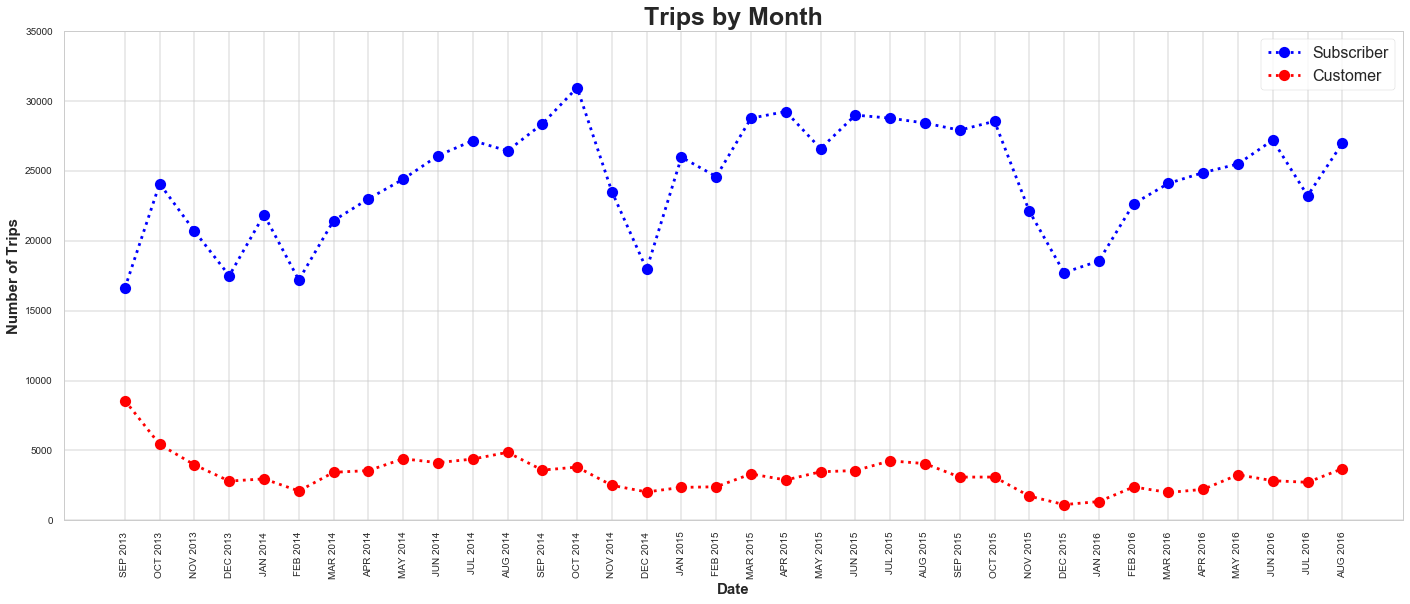

In [10]:
trips_per_month_df = pd.DataFrame()

y_max = -np.inf

for user_type in sorted(pd.unique(trips_df.user_type), reverse=True):
    t = trips_df[~((trips_df.start_date.dt.year == 2013) & (trips_df.start_date.dt.month == 8))]
    trips_per_month_df = t[t.user_type == user_type].groupby([t.start_date.dt.year, t.start_date.dt.month])['trip_id'].count().transpose()
    
    if trips_per_month_df.max() > y_max:
        y_max = trips_per_month_df.max()
    
    if user_type == 'Subscriber':
        print('Subscriber Mean Trips  {:6.4f}'. format(trips_per_month_df.mean()))
        print('Subscriber Range Trips {:6.4f}'. format((trips_per_month_df.max() - trips_per_month_df.min()) / 2.0))
        ax = trips_per_month_df.plot(linestyle=':', marker='o', figsize=(24,9), label=user_type, color='b')
    if user_type == 'Customer':
        print('Customer Mean Trips    {:6.4f}'. format(trips_per_month_df.mean()))
        print('Customer Range Trips   {:6.4f}'. format((trips_per_month_df.max() - trips_per_month_df.min()) / 2.0))
        ax = trips_per_month_df.plot(linestyle=':', marker='o', figsize=(24,9), label=user_type, color='r')
        

        

xticklabels = []
for year in sorted(pd.unique(t.start_date.dt.year)):
    for month in sorted(pd.unique(t[t.start_date.dt.year == year].start_date.dt.month)):
        
        tick_label = '%s %s' % (month_labels[month-1], year)
        xticklabels.append(tick_label)

ax.set_xticks(range(0, trips_per_month_df.shape[0]))
ax.set_xticklabels(xticklabels, rotation=90, size=TICK_FONT_SIZE)
ax.set_xlabel('Date', size=LABEL_FONT_SIZE, weight='bold')

y_tick_interval = 5000
y_max = math.ceil(y_max/y_tick_interval) * y_tick_interval
ax.set_ylim([0, y_max])
ax.set_yticks([y*y_tick_interval for y in np.arange(y_max/y_tick_interval + 1)])
ax.set_yticklabels([str(int(y*y_tick_interval)) for y in np.arange(y_max/y_tick_interval + 1)], size=TICK_FONT_SIZE)
ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')

ax.grid(alpha=0.5)
    
ax.legend(loc=1, frameon=True)
title = 'Trips by Month'
ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

image_title = '../charts/investigation_trips/Investigation_%s.png' % title.replace(' ', '_')
plt.savefig(image_title)

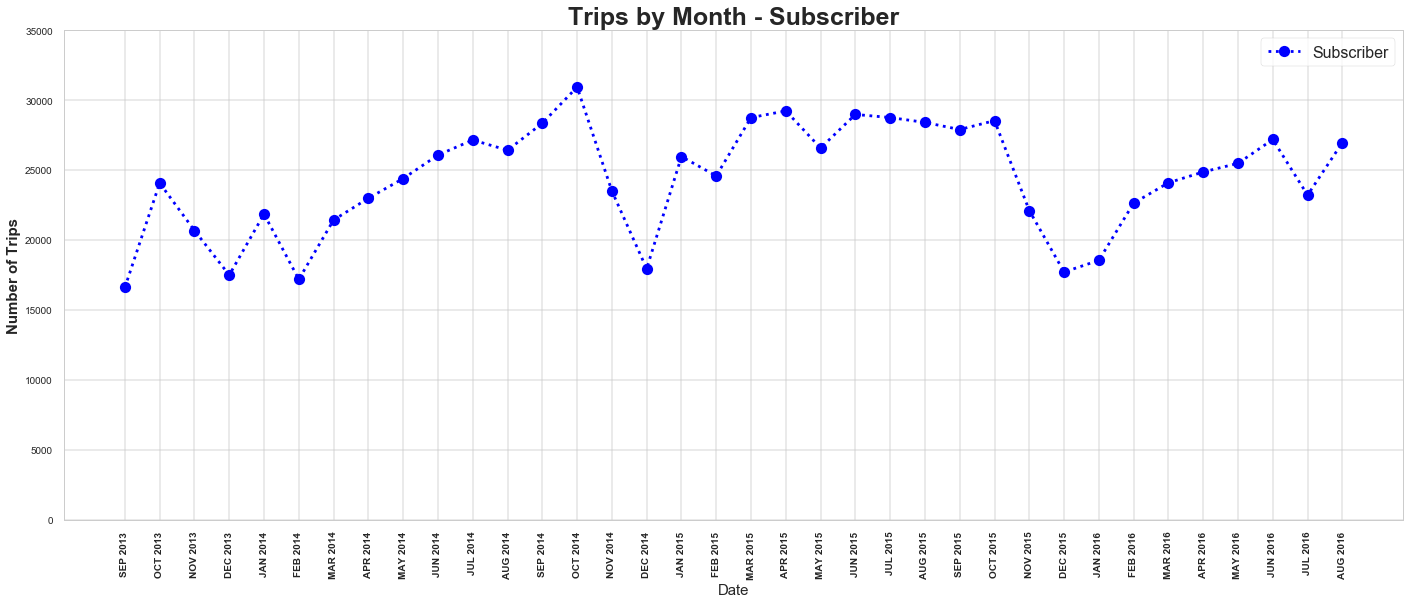

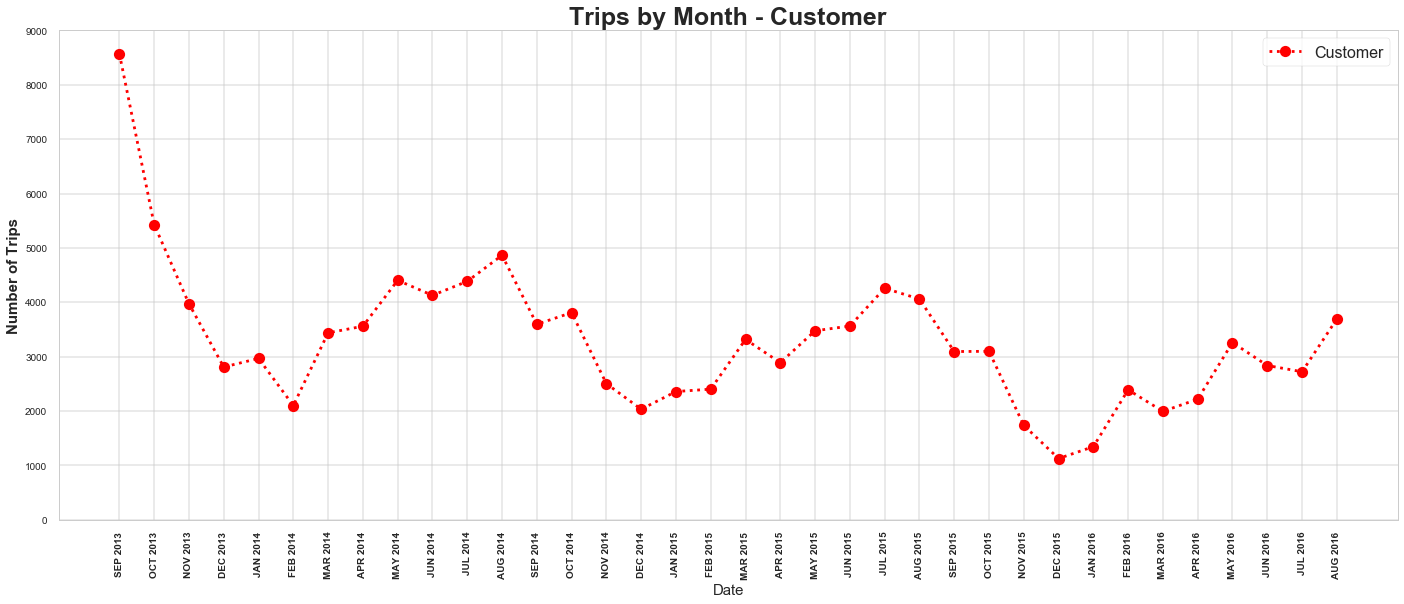

In [11]:
trips_per_month_df = pd.DataFrame()

for user_type in sorted(pd.unique(trips_df.user_type), reverse=True):
    y_max = -np.inf
    
    t = trips_df[~((trips_df.start_date.dt.year == 2013) & (trips_df.start_date.dt.month == 8))]
    trips_per_month_df = t[t.user_type == user_type].groupby([t.start_date.dt.year, t.start_date.dt.month])['trip_id'].count().transpose()
    
    if trips_per_month_df.max() > y_max:
        y_max = trips_per_month_df.max()

    
    
    
    if user_type == 'Subscriber':
        ax = trips_per_month_df.plot(linestyle=':', marker='o', figsize=(24,9), label=user_type, color='b')
    if user_type == 'Customer':
        ax = trips_per_month_df.plot(linestyle=':', marker='o', figsize=(24,9), label=user_type, color='r')
    
    xticklabels = []
    for year in sorted(pd.unique(t.start_date.dt.year)):
        for month in sorted(pd.unique(t[t.start_date.dt.year == year].start_date.dt.month)):



            tick_label = '%s %s' % (month_labels[month-1], year)
            xticklabels.append(tick_label)

    ax.set_xticks(range(0, trips_per_month_df.shape[0]))
    ax.set_xticklabels(xticklabels, rotation=90, size=TICK_FONT_SIZE, weight='bold')
    ax.set_xlabel('Date', size=LABEL_FONT_SIZE)
    

    if user_type == 'Subscriber':
        y_tick_interval = 5000
    if user_type == 'Customer':
        y_tick_interval = 1000

    y_max = math.ceil(y_max/y_tick_interval) * y_tick_interval
    ax.set_ylim([0, y_max])
    ax.set_yticks([y*y_tick_interval for y in np.arange(y_max/y_tick_interval + 1)])
    ax.set_yticklabels([str(int(y*y_tick_interval)) for y in np.arange(y_max/y_tick_interval + 1)], size=TICK_FONT_SIZE)
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')

    ax.grid(alpha=0.5)
    
    ax.legend(loc=1, frameon=True)
    title = 'Trips by Month - %s' % user_type
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    
    image_title = '../charts/investigation_trips/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)
    plt.show()

# Analysis 2 - Usage Patterns for San Francisco Subscribers

<ul>
    <li>at any given time, how many Subscirber trips are in in process?</li>
    <li>Hourly Start and End counts</li>
    <li>Day of Week Start and End counts</li>
    <li>Month of Year Start and End counts</li>
</ul>

In [12]:
subscriber_trips_df = trips_df[trips_df.user_type == 'Subscriber'].copy()

sf_subscriber_trips_df = subscriber_trips_df[(subscriber_trips_df.start_zip == 94107) & (subscriber_trips_df.end_zip == 94107)].copy()
sf_subscriber_trips_df.reset_index(inplace=True, drop=True)
sf_subscriber_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797541 entries, 0 to 797540
Data columns (total 23 columns):
trip_id               797541 non-null int64
duration              797541 non-null int64
start_date            797541 non-null datetime64[ns]
start_station_name    797541 non-null object
start_terminal        797541 non-null int64
end_date              797541 non-null datetime64[ns]
end_station_name      797541 non-null object
end_terminal          797541 non-null int64
bike_id               797541 non-null int64
user_type             797541 non-null category
user_zip              797541 non-null int64
duration_minutes      797541 non-null float64
start_zip             797541 non-null int64
end_zip               797541 non-null int64
max_temp              797541 non-null float64
mean_temp             797541 non-null float64
min_temp              797541 non-null float64
max_wind              797541 non-null float64
mean_wind             797541 non-null float64
max_gust          

In [13]:
sf_subscriber_trips_df.head()

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,...,end_zip,max_temp,mean_temp,min_temp,max_wind,mean_wind,max_gust,precipitation,cloud_cover,events
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,...,94107,74.0,68.0,61.0,23.0,11.0,28.0,0.0,4.0,NaN


## Subscriber Trips by Hour of Day in each Region

morning commute start share    33.6857
evening commute start share    30.8227
  total commute start share    64.5085
morning commute end share      33.1193
evening commute end share      30.9270
  total commute end share      64.0463


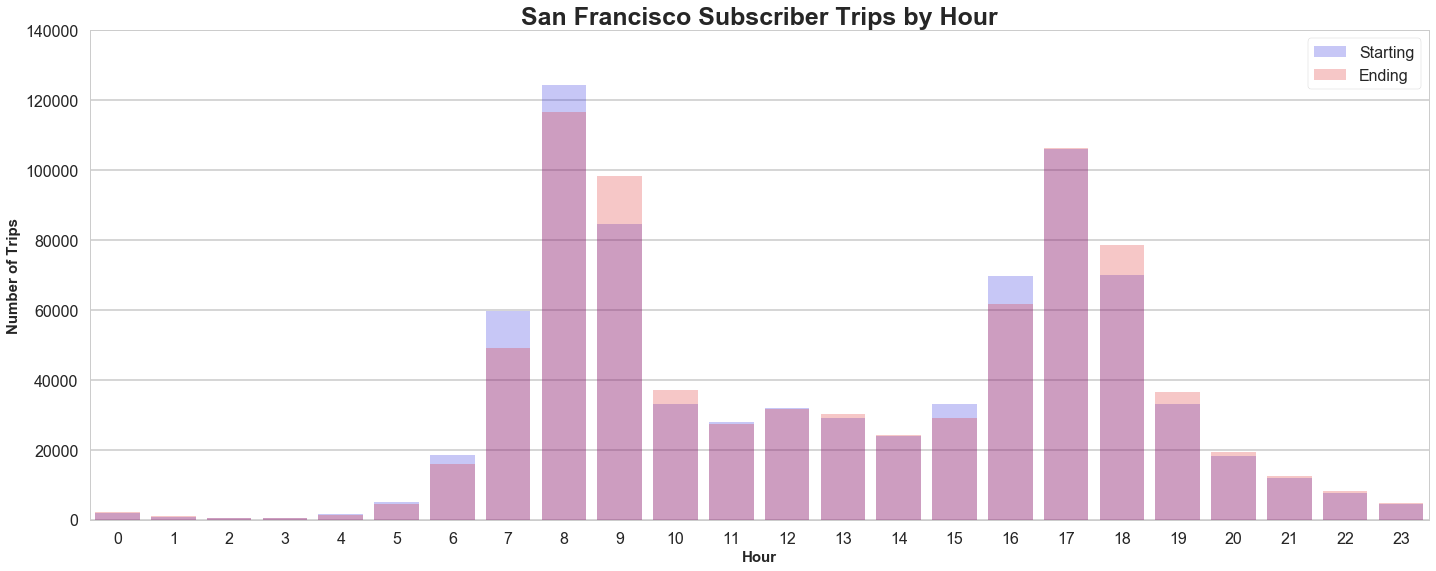

morning commute start share    26.9339
evening commute start share    33.1689
  total commute start share    60.1028
morning commute end share      27.2614
evening commute end share      33.1825
  total commute end share      60.4439


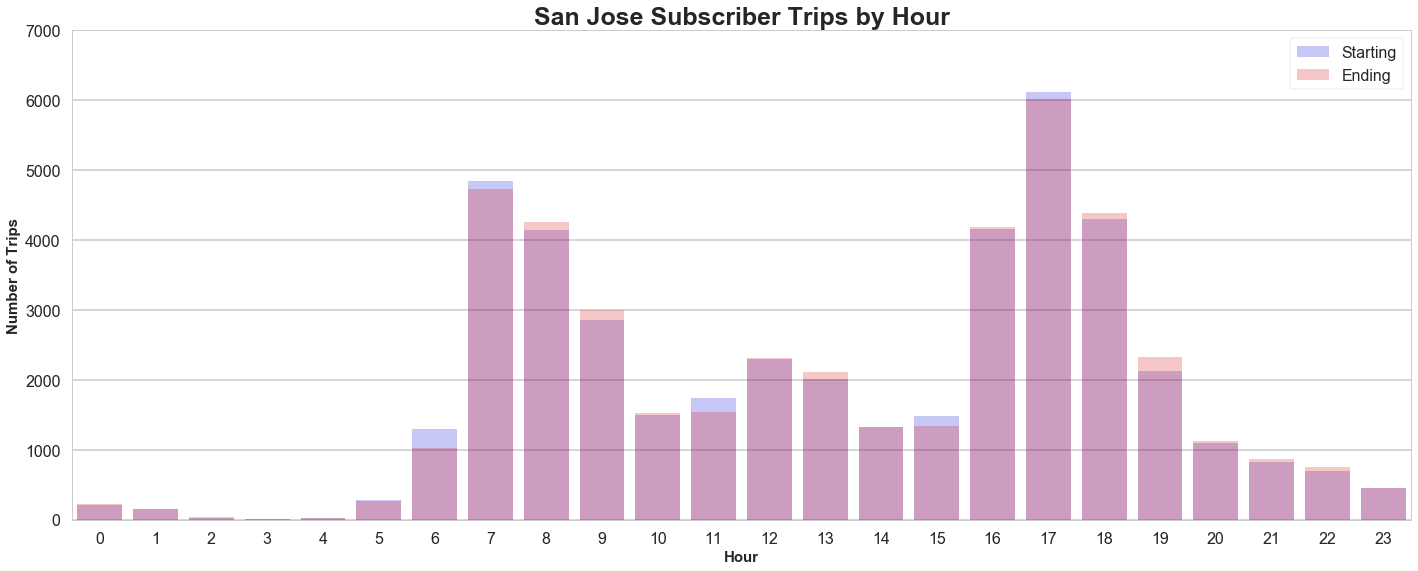

morning commute start share    38.4897
evening commute start share    34.9842
  total commute start share    73.4740
morning commute end share      38.0143
evening commute end share      34.0689
  total commute end share      72.0832


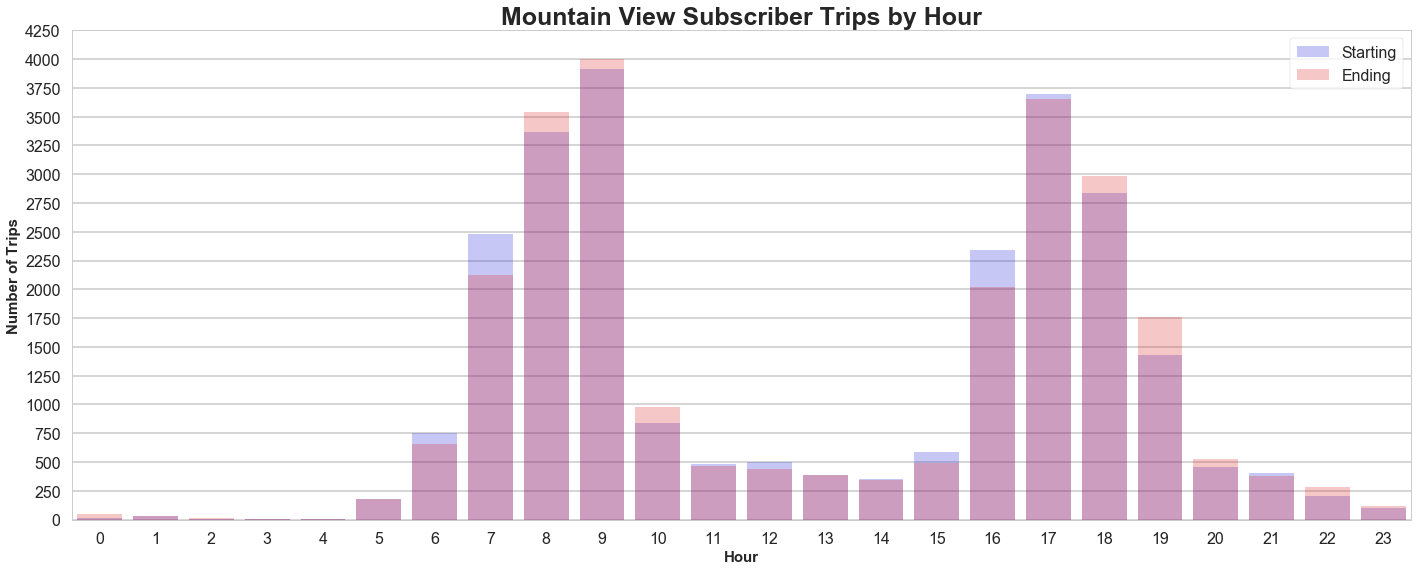

morning commute start share    36.0911
evening commute start share    33.0430
  total commute start share    69.1341
morning commute end share      33.6070
evening commute end share      34.1766
  total commute end share      67.7835


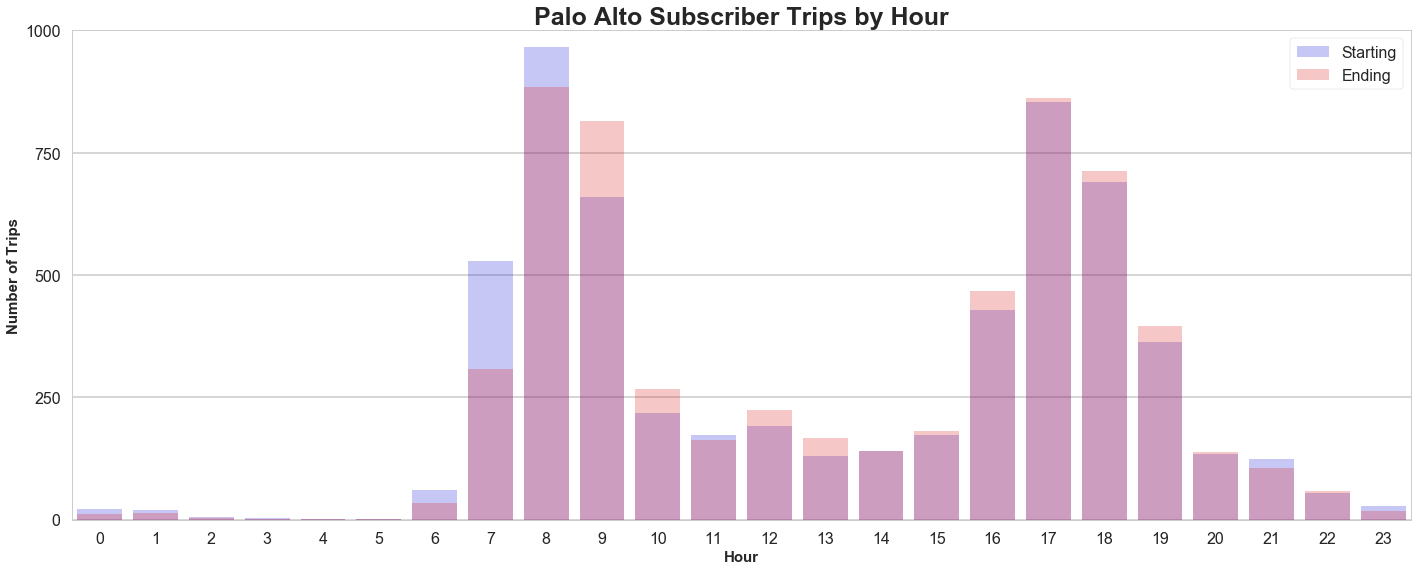

morning commute start share    35.2342
evening commute start share    35.3312
  total commute start share    70.5654
morning commute end share      37.4103
evening commute end share      32.9909
  total commute end share      70.4012


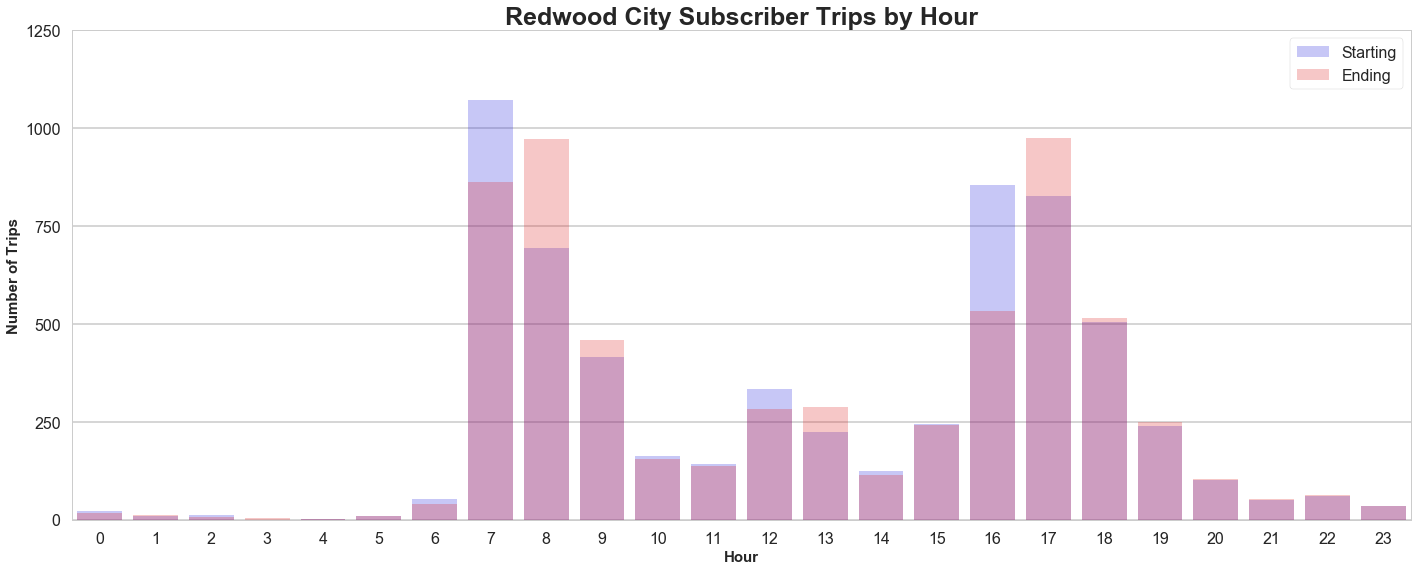

In [14]:
for zip_code in ordered_zipcodes:
    
    tmp_df = pd.DataFrame()
    
    subscriber_trips = trips_df[trips_df.user_type == 'Subscriber'].copy()
    
    starting_y = subscriber_trips[subscriber_trips.start_zip == zip_code].groupby(subscriber_trips[subscriber_trips.start_zip == zip_code].start_date.dt.hour)['trip_id'].count()
    ending_y = subscriber_trips[subscriber_trips.end_zip == zip_code].groupby(subscriber_trips[subscriber_trips.end_zip == zip_code].end_date.dt.hour)['trip_id'].count()
        
    tmp_df = pd.concat([starting_y, ending_y], axis=1)
    tmp_df = tmp_df.fillna(0)
    tmp_df.columns = ['starting', 'ending']
    tmp_df.starting = tmp_df.starting.astype('int')
    tmp_df.ending = tmp_df.ending.astype('int')
    
    tmp_df['starting_share'] = tmp_df.starting / tmp_df.starting.sum() * 100.
    tmp_df['ending_share'] = tmp_df.ending / tmp_df.ending.sum() * 100.
    
    morning_commute_start_share = tmp_df.iloc[7:10,2].sum()
    evening_commute_start_share = tmp_df.iloc[16:19,2].sum()
    commute_start_share = morning_commute_start_share + evening_commute_start_share
    print('morning commute start share    {:2.4f}'.format(morning_commute_start_share))
    print('evening commute start share    {:2.4f}'.format(evening_commute_start_share))
    print('  total commute start share    {:2.4f}'.format(commute_start_share))

    
    morning_commute_end_share = tmp_df.iloc[7:10,3].sum()
    evening_commute_end_share = tmp_df.iloc[16:19,3].sum()
    commute_end_share = morning_commute_end_share + evening_commute_end_share
    print('morning commute end share      {:2.4f}'.format(morning_commute_end_share))
    print('evening commute end share      {:2.4f}'.format(evening_commute_end_share))
    print('  total commute end share      {:2.4f}'.format(commute_end_share))

    
    x_ticks = [x for x in range(0, tmp_df.shape[0])]
    
    # Trips by Hour by Customer Type
    plt.subplots(figsize=(24,9))

    ax = sns.barplot(x = x_ticks , y = 'starting', data=tmp_df, color='b', alpha = 0.25, label='Starting')
    sns.barplot(x = x_ticks , y = 'ending', data=tmp_df, color='r', alpha = 0.25, label='Ending', ax=ax)
    
    title = '%s Subscriber Trips by Hour' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    ax.set_xlabel('Hour', size=LABEL_FONT_SIZE, weight='bold')

    
    # set y axis
    y_interval = tmp_df.max().max()/5000
    
    if y_interval > 10:
        y_interval = 20000
    elif y_interval <= 10 and y_interval > 1:
        y_interval = 1000
    else:
        y_interval = 250

    y_max = -np.inf
    y_max = tmp_df.max().max()
    y_max = math.ceil(y_max/y_interval) * y_interval
    
    ax.set_ylim([0, y_max])
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')

    ax.legend(loc=1, frameon=True)
    
    image_title = '../charts/investigation_trips/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)
    plt.show()

## Subscriber Trips by Day of Week in each Region

weekday commute start share    96.9727
weekend commute start share    3.0273
weekday commute end share      96.9683
weekend commute end share      3.0317


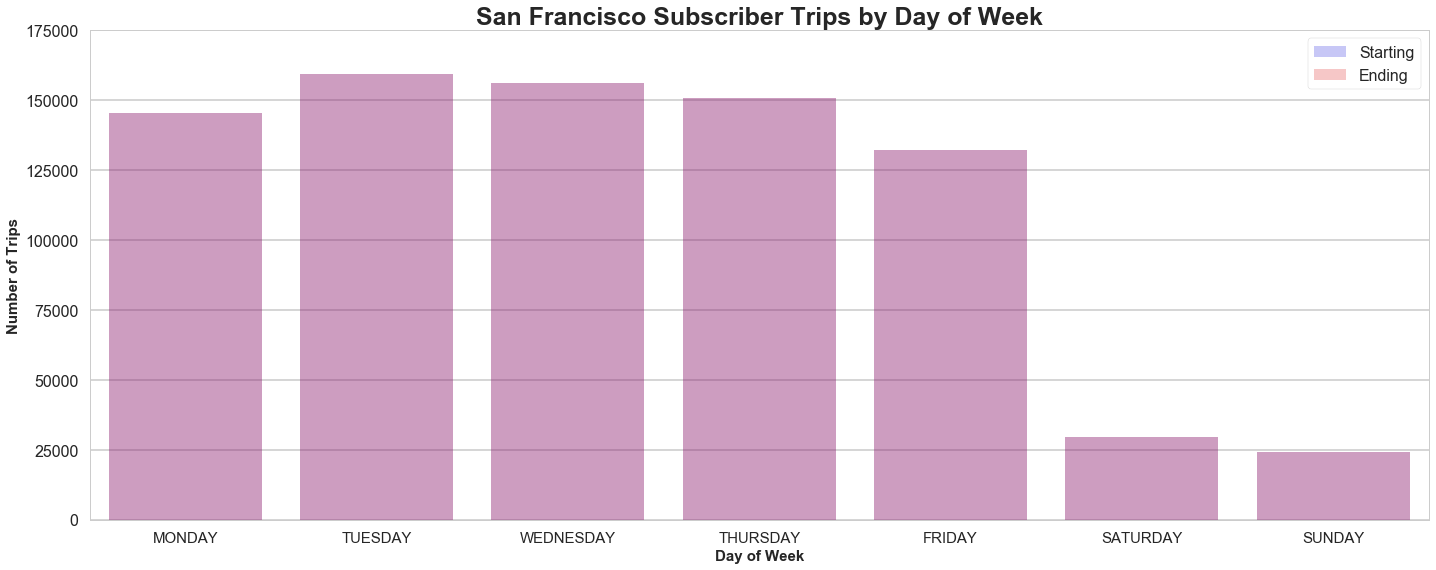

weekday commute start share    95.5432
weekend commute start share    4.4568
weekday commute end share      95.5228
weekend commute end share      4.4772


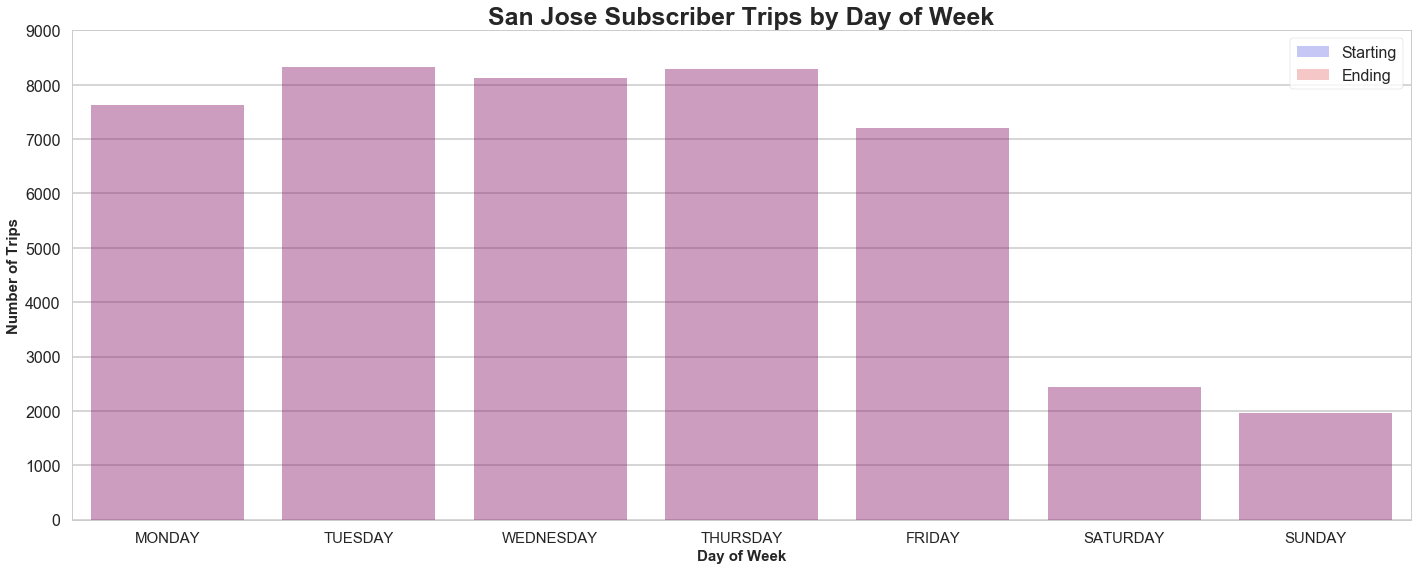

weekday commute start share    97.5552
weekend commute start share    2.4448
weekday commute end share      97.5572
weekend commute end share      2.4428


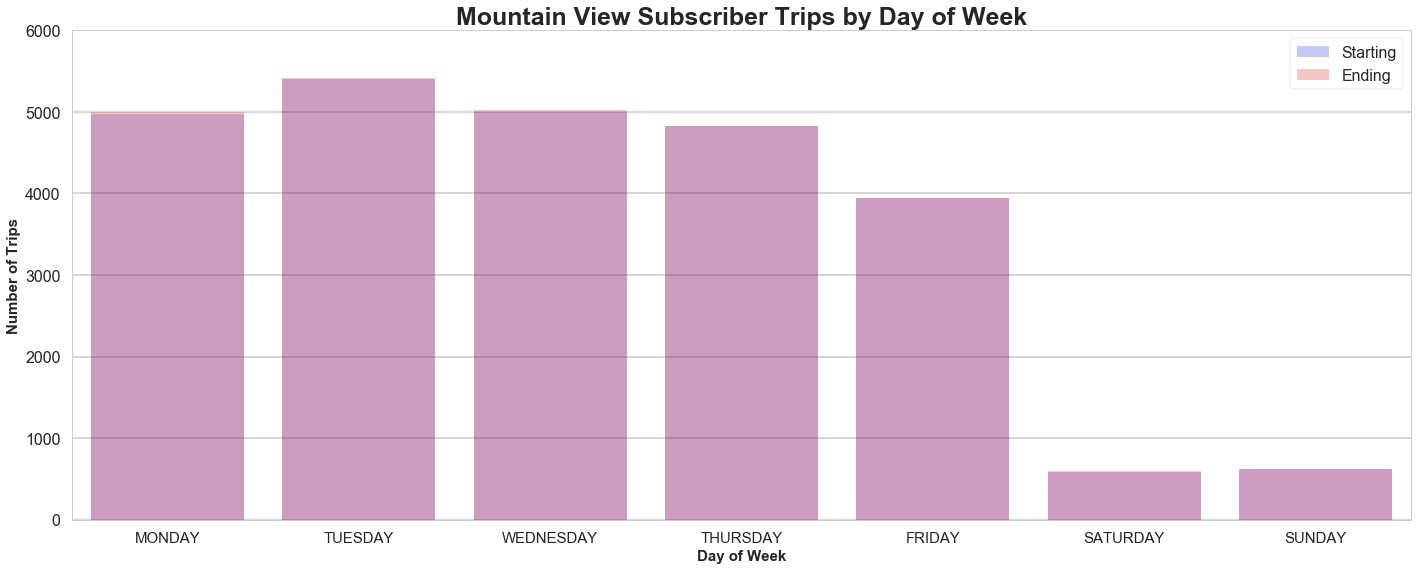

weekday commute start share    96.1983
weekend commute start share    3.8017
weekday commute end share      96.0965
weekend commute end share      3.9035


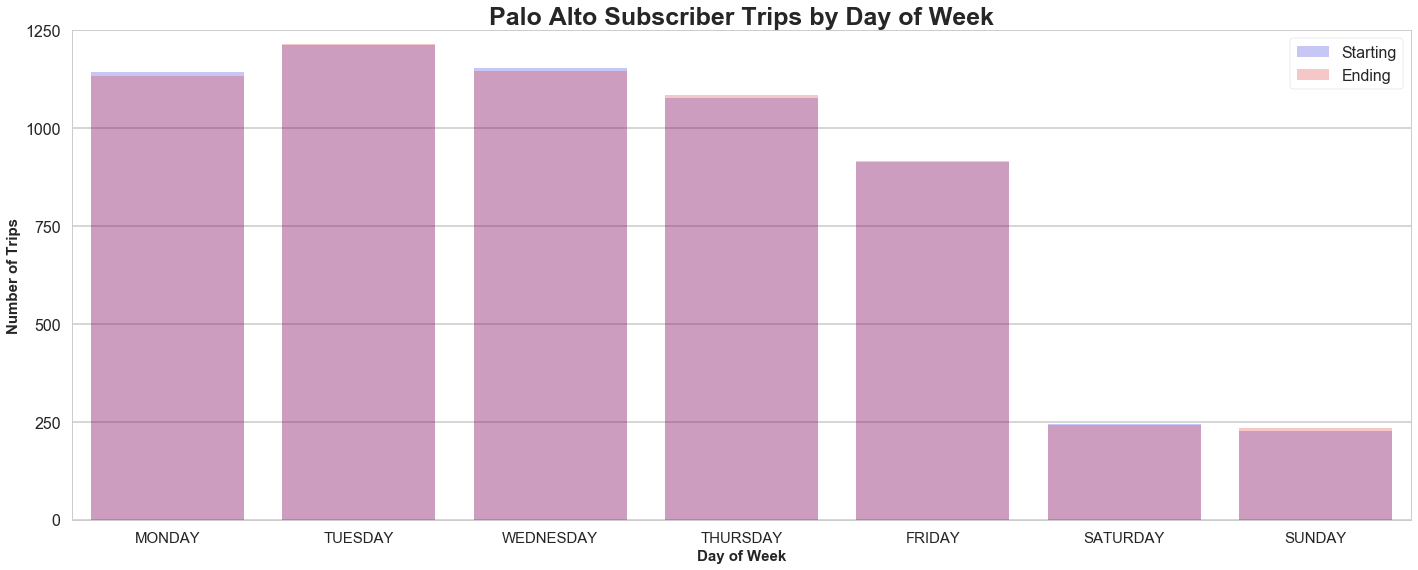

weekday commute start share    97.8191
weekend commute start share    2.1809
weekday commute end share      97.8311
weekend commute end share      2.1689


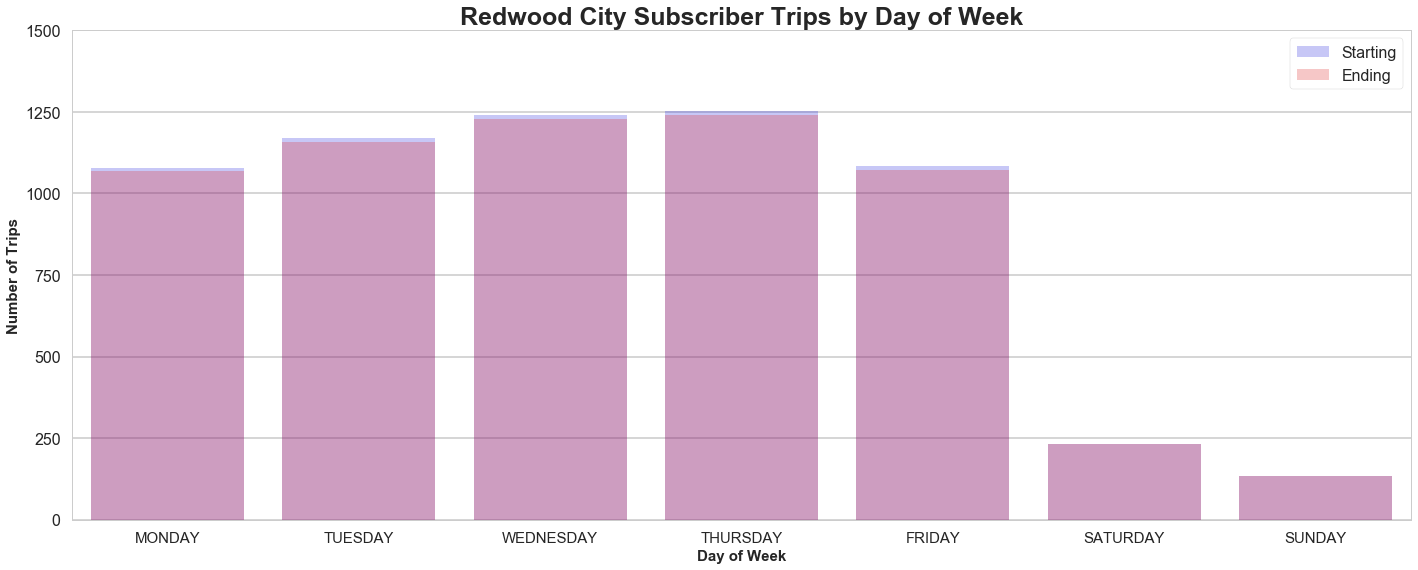

In [15]:
for zip_code in ordered_zipcodes:
    
    tmp_df = pd.DataFrame()
    
    subscriber_trips = trips_df[trips_df.user_type == 'Subscriber'].copy()
    
    starting_y = subscriber_trips[subscriber_trips.start_zip == zip_code].groupby(subscriber_trips[subscriber_trips.start_zip == zip_code].start_date.dt.dayofweek)['trip_id'].count()
    ending_y = subscriber_trips[subscriber_trips.end_zip == zip_code].groupby(subscriber_trips[subscriber_trips.end_zip == zip_code].end_date.dt.dayofweek)['trip_id'].count()
   
    tmp_df = pd.concat([starting_y, ending_y], axis=1)
    tmp_df = tmp_df.fillna(0)
    tmp_df.columns = ['starting', 'ending']
    tmp_df.starting = tmp_df.starting.astype('int')
    tmp_df.ending = tmp_df.ending.astype('int')
    
    tmp_df['starting_share'] = tmp_df.starting / tmp_df.starting.sum() * 100.
    tmp_df['ending_share'] = tmp_df.ending / tmp_df.ending.sum() * 100.
    
#     print(tmp_df[['starting_share', 'ending_share']])
    
    weekday_commute_start_share = tmp_df.iloc[0:6,2].sum()
    weekend_commute_start_share = tmp_df.iloc[6:,2].sum()
    print('weekday commute start share    {:2.4f}'.format(weekday_commute_start_share))
    print('weekend commute start share    {:2.4f}'.format(weekend_commute_start_share))

    
    weekday_commute_end_share = tmp_df.iloc[0:6,3].sum()
    weekend_commute_end_share = tmp_df.iloc[6:,3].sum()
    print('weekday commute end share      {:2.4f}'.format(weekday_commute_end_share))
    print('weekend commute end share      {:2.4f}'.format(weekend_commute_end_share))
    
    # Trips by Hour by Customer Type
    plt.subplots(figsize=(24,9))

    ax = sns.barplot(x = day_labels_full , y = 'starting', data=tmp_df, color='b', alpha = 0.25, label='Starting')
    sns.barplot(x = day_labels_full , y = 'ending', data=tmp_df, color='r', alpha = 0.25, label='Ending', ax=ax)

    
    title = '%s Subscriber Trips by Day of Week' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
    
    ax.set_xticklabels(day_labels_full, size=TICK_FONT_SIZE*1.5)
    
    # set y axis
    y_interval = tmp_df.max().max()/5000

    
    if y_interval > 30:
        y_interval = 25000
    elif y_interval < 10  and y_interval > 1:
        y_interval = 1000
    else:
        y_interval = 250
        
    y_max = -np.inf
    y_max = tmp_df.max().max()
    y_max = math.ceil(y_max/y_interval) * y_interval
    
    ax.set_ylim([0, y_max])
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')

    ax.legend(loc=1, frameon=True)
    
    image_title = '../charts/investigation_trips/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)
    plt.show()

## Subscriber Trips by Day of Week in each Region - Commute Hours Only
<ul>
    <li>Morning Commute Hours are 7am-10pm</li>
    <li>Evening Commute Hours are 4pm-7pm</li>
</ul>

weekday commute start share    98.4443
weekend commute start share    1.5557
weekday commute end share      98.4442
weekend commute end share      1.5558


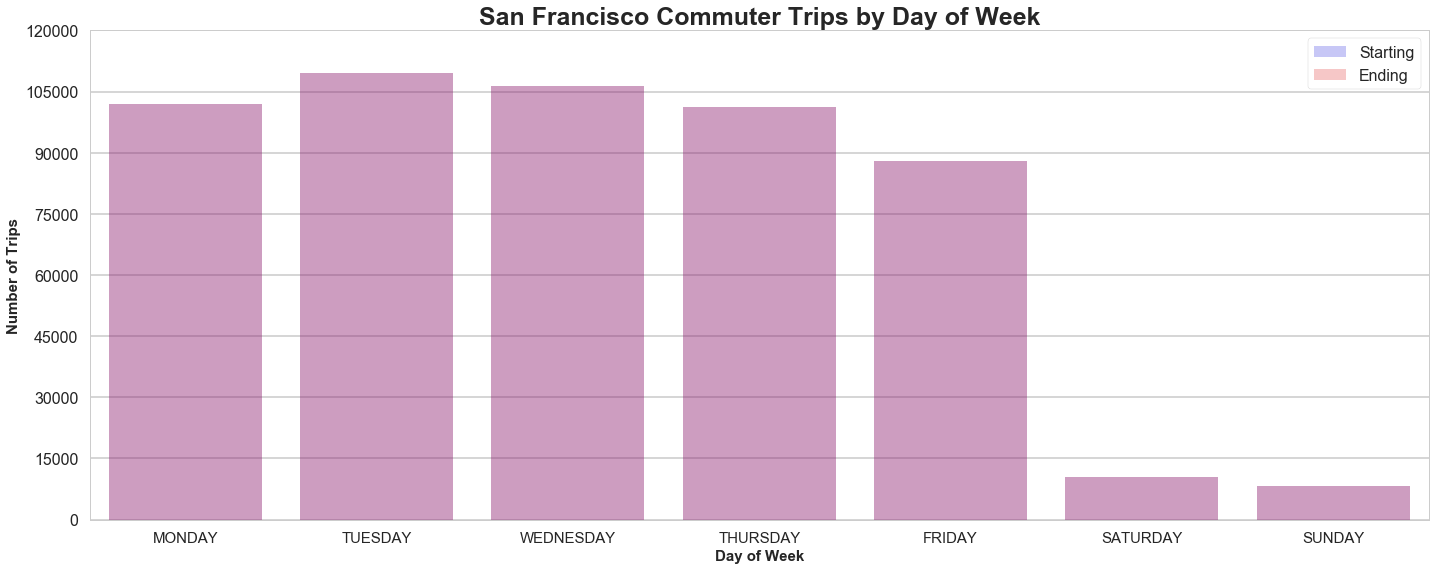

weekday commute start share    97.7713
weekend commute start share    2.2287
weekday commute end share      97.7713
weekend commute end share      2.2287


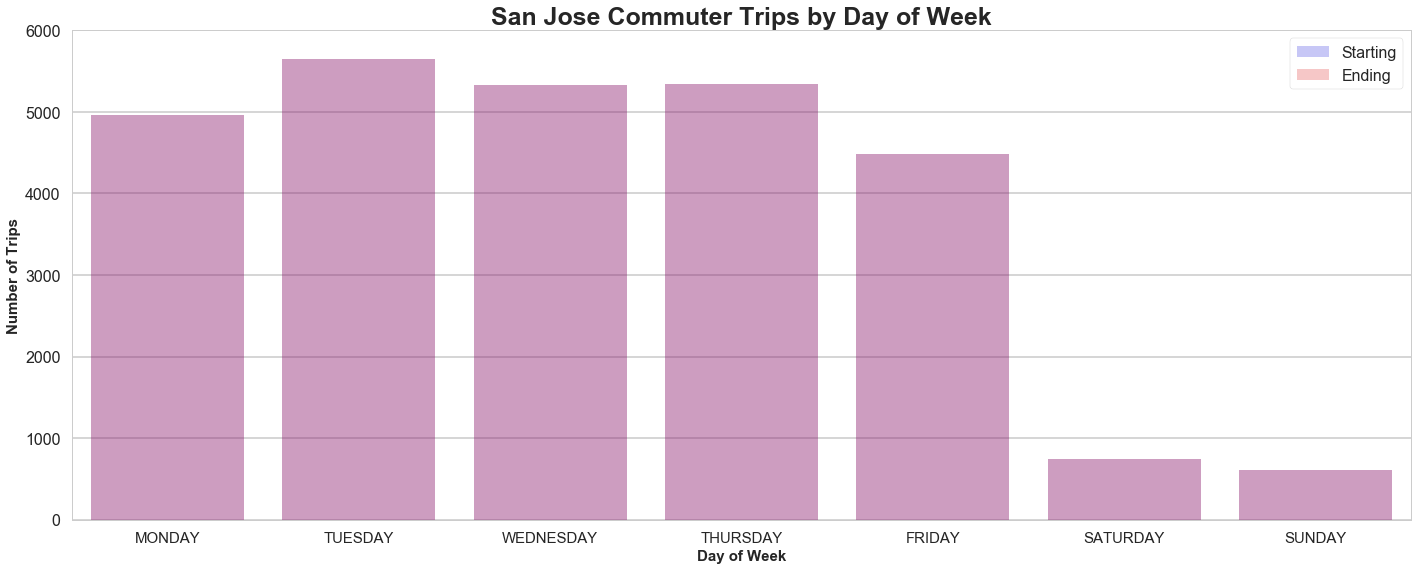

weekday commute start share    98.9672
weekend commute start share    1.0328
weekday commute end share      98.9795
weekend commute end share      1.0205


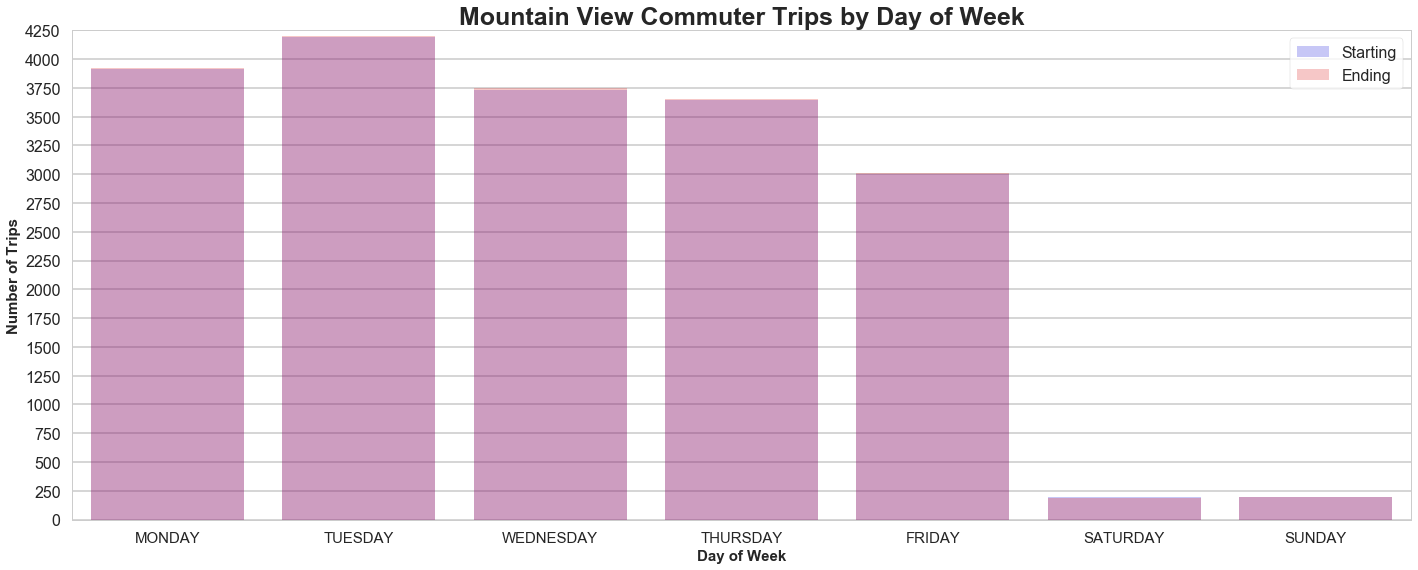

weekday commute start share    98.1366
weekend commute start share    1.8634
weekday commute end share      98.0984
weekend commute end share      1.9016


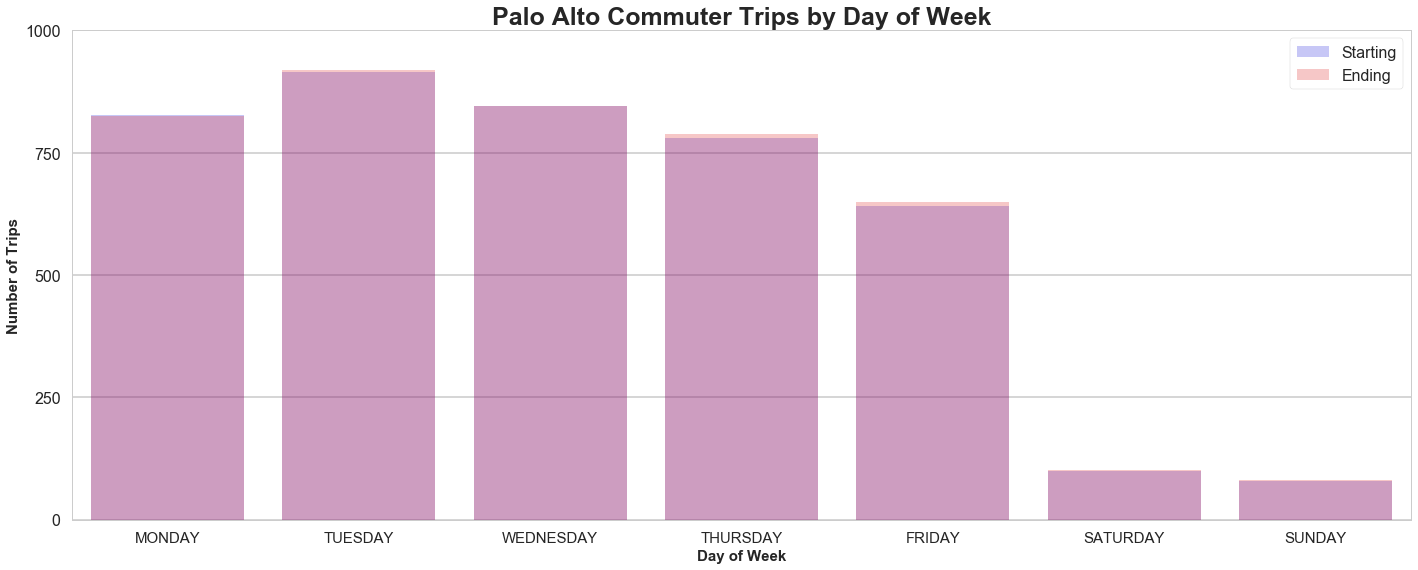

weekday commute start share    99.0249
weekend commute start share    0.9751
weekday commute end share      99.0133
weekend commute end share      0.9867


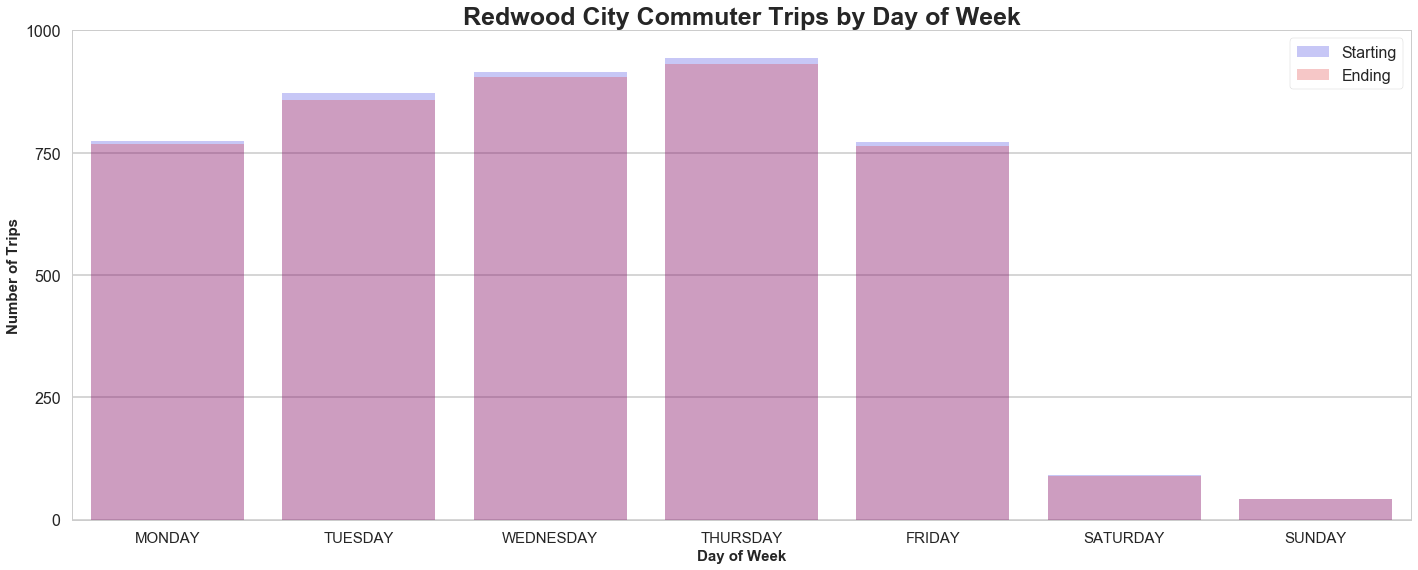

In [16]:
for zip_code in ordered_zipcodes:
    
    tmp_df = pd.DataFrame()
    
    subscriber_trips = trips_df[trips_df.user_type == 'Subscriber'].copy()
    
    commuter_trips = subscriber_trips[((subscriber_trips.start_date.dt.hour >= 7) & (subscriber_trips.start_date.dt.hour < 10)) | 
                                      ((subscriber_trips.end_date.dt.hour >= 7) & (subscriber_trips.end_date.dt.hour < 10)) | 
                                      ((subscriber_trips.start_date.dt.hour >= 16) & (subscriber_trips.start_date.dt.hour < 19)) | 
                                      ((subscriber_trips.end_date.dt.hour >= 16) & (subscriber_trips.end_date.dt.hour < 19))]
    
    starting_y = commuter_trips[commuter_trips.start_zip == zip_code].groupby(commuter_trips[commuter_trips.start_zip == zip_code].start_date.dt.dayofweek)['trip_id'].count()
    ending_y = commuter_trips[commuter_trips.end_zip == zip_code].groupby(commuter_trips[commuter_trips.end_zip == zip_code].end_date.dt.dayofweek)['trip_id'].count()
   
    tmp_df = pd.concat([starting_y, ending_y], axis=1)
    tmp_df = tmp_df.fillna(0)
    tmp_df.columns = ['starting', 'ending']
    tmp_df.starting = tmp_df.starting.astype('int')
    tmp_df.ending = tmp_df.ending.astype('int')
    
    tmp_df['starting_share'] = tmp_df.starting / tmp_df.starting.sum() * 100.
    tmp_df['ending_share'] = tmp_df.ending / tmp_df.ending.sum() * 100.
    
#     print(tmp_df[['starting_share', 'ending_share']])
    
    weekday_commute_start_share = tmp_df.iloc[0:6,2].sum()
    weekend_commute_start_share = tmp_df.iloc[6:,2].sum()
    print('weekday commute start share    {:2.4f}'.format(weekday_commute_start_share))
    print('weekend commute start share    {:2.4f}'.format(weekend_commute_start_share))

    
    weekday_commute_end_share = tmp_df.iloc[0:6,3].sum()
    weekend_commute_end_share = tmp_df.iloc[6:,3].sum()
    print('weekday commute end share      {:2.4f}'.format(weekday_commute_end_share))
    print('weekend commute end share      {:2.4f}'.format(weekend_commute_end_share))
    
    # Trips by Hour by Customer Type
    plt.subplots(figsize=(24,9))

    ax = sns.barplot(x = day_labels_full , y = 'starting', data=tmp_df, color='b', alpha = 0.25, label='Starting')
    sns.barplot(x = day_labels_full , y = 'ending', data=tmp_df, color='r', alpha = 0.25, label='Ending', ax=ax)

    
    title = '%s Commuter Trips by Day of Week' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    ax.set_xlabel('Day of Week', size=LABEL_FONT_SIZE, weight='bold')
    
    ax.set_xticklabels(day_labels_full, size=TICK_FONT_SIZE*1.5)
    
    # set y axis
    y_interval = tmp_df.max().max()/5000

    
    if y_interval > 10:
        y_interval = 15000
    elif y_interval < 10  and y_interval > 1:
        y_interval = 1000
    else:
        y_interval = 250
        
    y_max = -np.inf
    y_max = tmp_df.max().max()
    y_max = math.ceil(y_max/y_interval) * y_interval
    
    ax.set_ylim([0, y_max])
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')

    ax.legend(loc=1, frameon=True)
    
    image_title = '../charts/investigation_trips/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)
    plt.show()

## Subscriber Trips by Hour of Day in each Region - Weekdays Only
<ul>
    <li>Morning Commute Hours are 7am-10pm</li>
    <li>Evening Commute Hours are 4pm-7pm</li>
</ul>

morning commute start share    34.3999
evening commute start share    31.1222
  total commute start share    65.5221
morning commute end share      33.8498
evening commute end share      31.2062
  total commute end share      65.0560


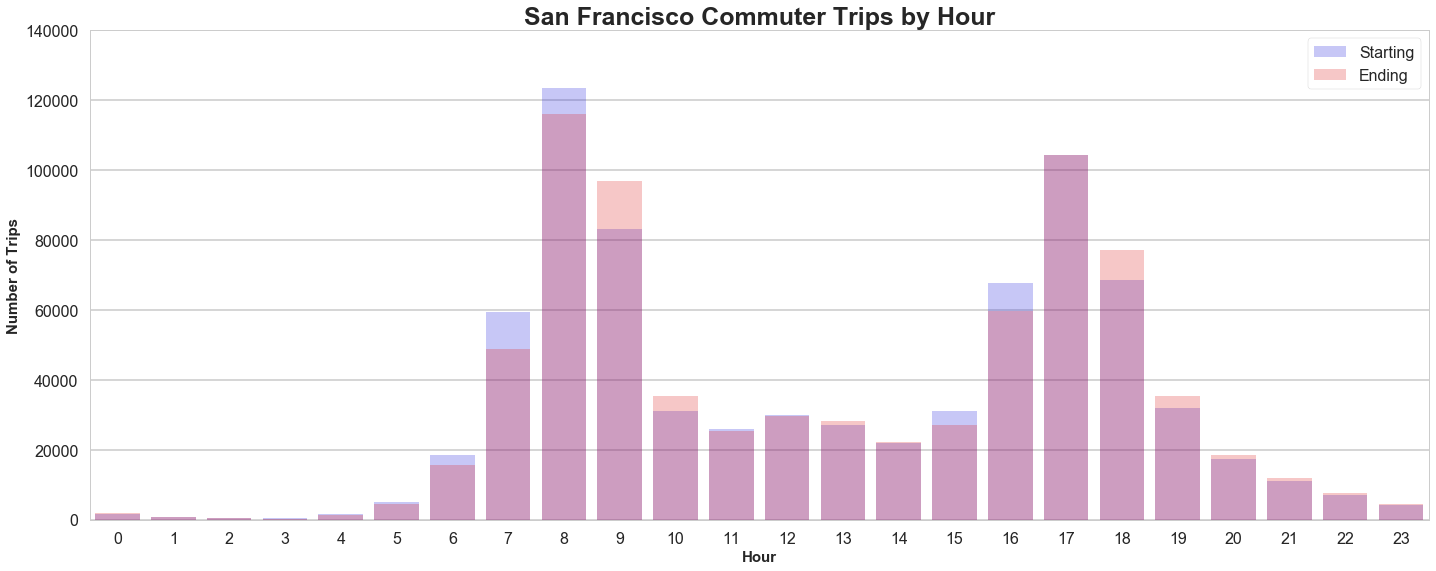

morning commute start share    27.8430
evening commute start share    33.7206
  total commute start share    61.5635
morning commute end share      28.2167
evening commute end share      33.7253
  total commute end share      61.9421


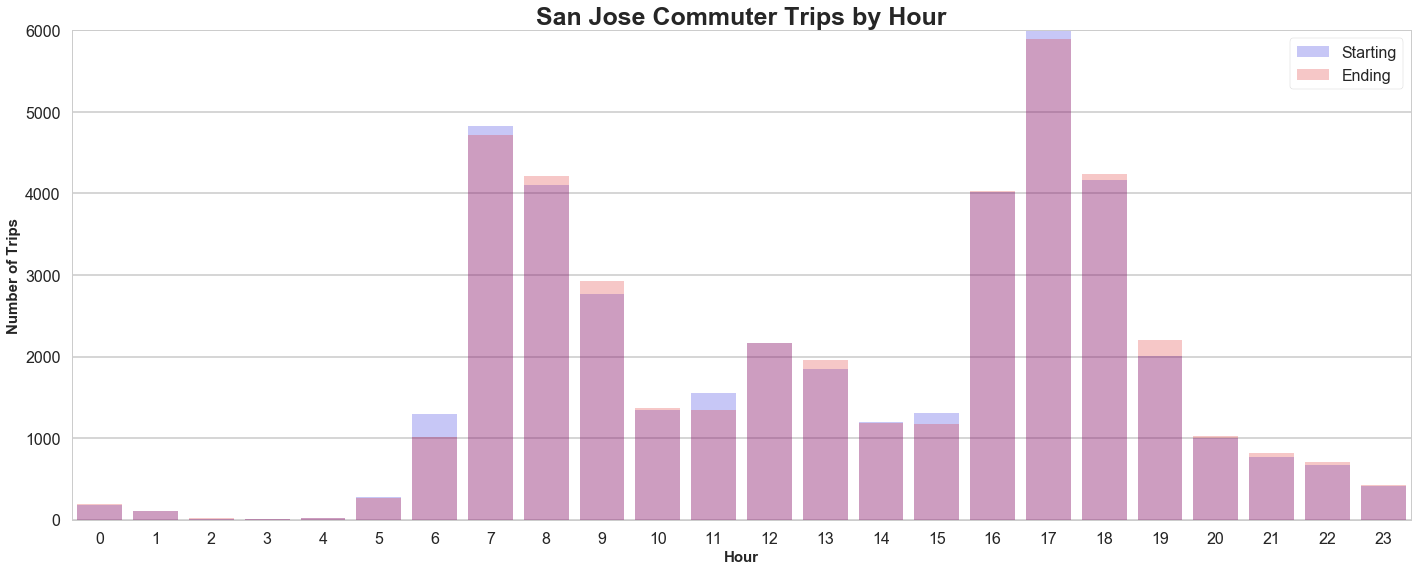

morning commute start share    39.1631
evening commute start share    35.4235
  total commute start share    74.5866
morning commute end share      38.7153
evening commute end share      34.4691
  total commute end share      73.1844


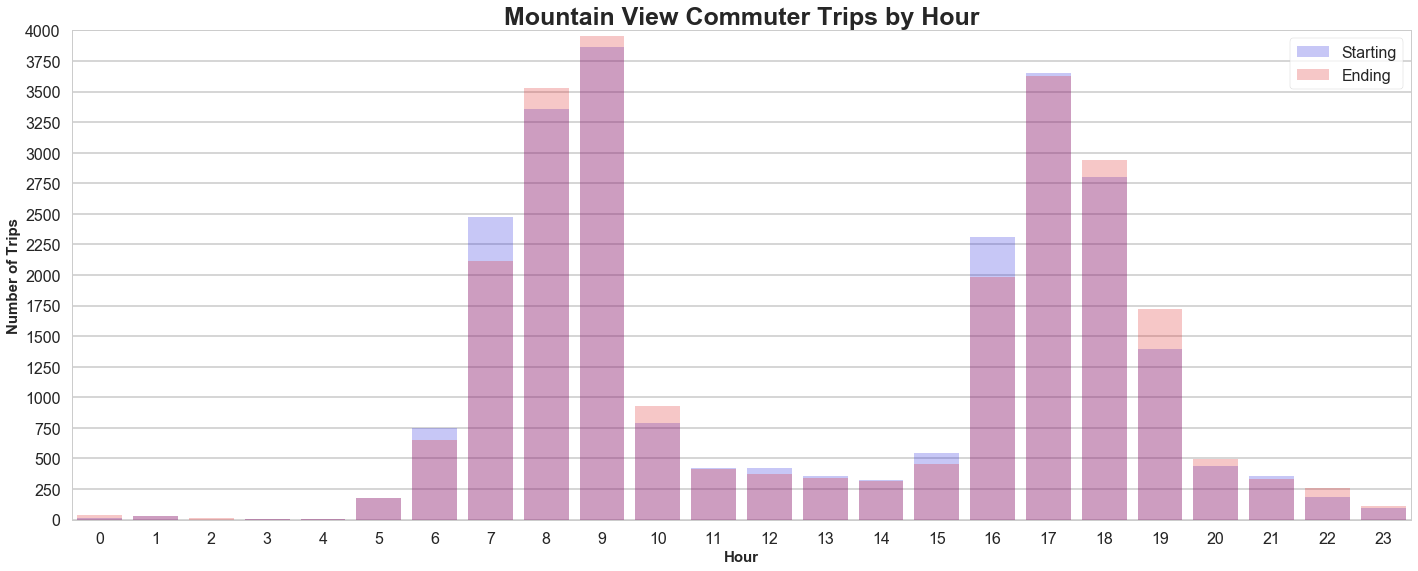

morning commute start share    37.2518
evening commute start share    33.3682
  total commute start share    70.6200
morning commute end share      34.7978
evening commute end share      34.4491
  total commute end share      69.2469


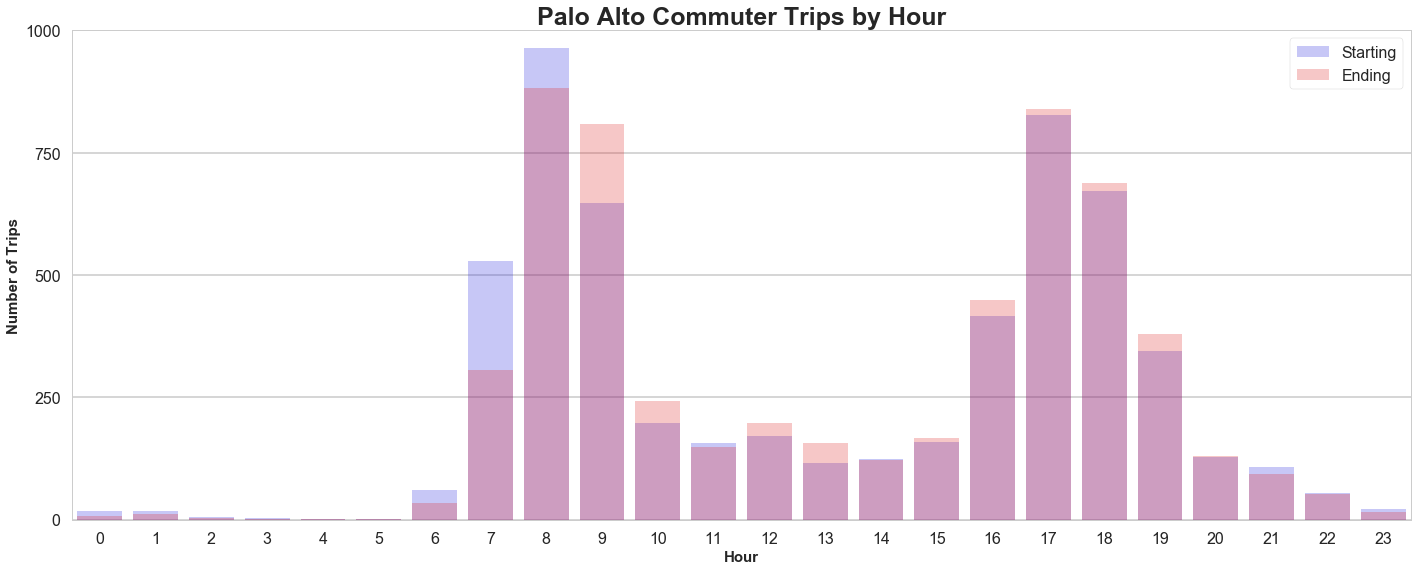

morning commute start share    35.8712
evening commute start share    35.5739
  total commute start share    71.4451
morning commute end share      38.1230
evening commute end share      33.1555
  total commute end share      71.2785


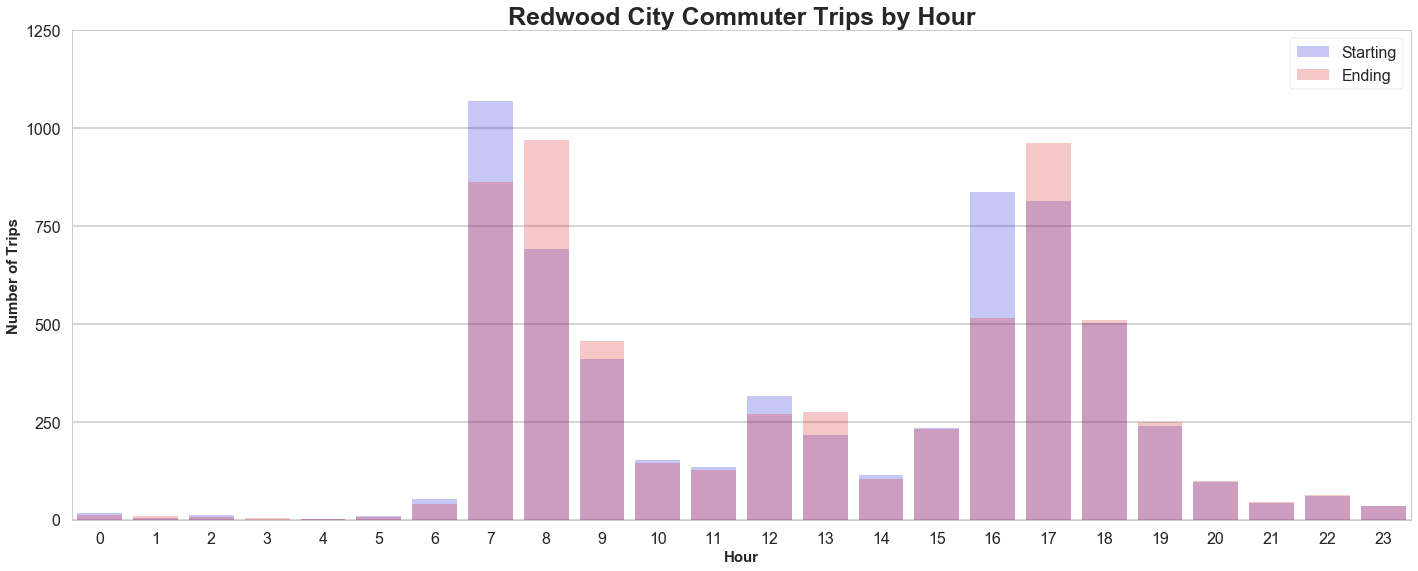

In [17]:
for zip_code in ordered_zipcodes:
    
    tmp_df = pd.DataFrame()
    
    subscriber_trips = trips_df[trips_df.user_type == 'Subscriber'].copy()
    
    commuter_trips = subscriber_trips[(subscriber_trips.start_date.dt.dayofweek < 6) & (subscriber_trips.end_date.dt.dayofweek < 6)]
    
    starting_y = commuter_trips[commuter_trips.start_zip == zip_code].groupby(commuter_trips[commuter_trips.start_zip == zip_code].start_date.dt.hour)['trip_id'].count()
    ending_y = commuter_trips[commuter_trips.end_zip == zip_code].groupby(commuter_trips[commuter_trips.end_zip == zip_code].end_date.dt.hour)['trip_id'].count()
        
    tmp_df = pd.concat([starting_y, ending_y], axis=1)
    tmp_df = tmp_df.fillna(0)
    tmp_df.columns = ['starting', 'ending']
    tmp_df.starting = tmp_df.starting.astype('int')
    tmp_df.ending = tmp_df.ending.astype('int')
    
    tmp_df['starting_share'] = tmp_df.starting / tmp_df.starting.sum() * 100.
    tmp_df['ending_share'] = tmp_df.ending / tmp_df.ending.sum() * 100.
    
    morning_commute_start_share = tmp_df.iloc[7:10,2].sum()
    evening_commute_start_share = tmp_df.iloc[16:19,2].sum()
    commute_start_share = morning_commute_start_share + evening_commute_start_share
    print('morning commute start share    {:2.4f}'.format(morning_commute_start_share))
    print('evening commute start share    {:2.4f}'.format(evening_commute_start_share))
    print('  total commute start share    {:2.4f}'.format(commute_start_share))

    
    morning_commute_end_share = tmp_df.iloc[7:10,3].sum()
    evening_commute_end_share = tmp_df.iloc[16:19,3].sum()
    commute_end_share = morning_commute_end_share + evening_commute_end_share
    print('morning commute end share      {:2.4f}'.format(morning_commute_end_share))
    print('evening commute end share      {:2.4f}'.format(evening_commute_end_share))
    print('  total commute end share      {:2.4f}'.format(commute_end_share))

    
    x_ticks = [x for x in range(0, tmp_df.shape[0])]
    
    # Trips by Hour by Customer Type
    plt.subplots(figsize=(24,9))

    ax = sns.barplot(x = x_ticks , y = 'starting', data=tmp_df, color='b', alpha = 0.25, label='Starting')
    sns.barplot(x = x_ticks , y = 'ending', data=tmp_df, color='r', alpha = 0.25, label='Ending', ax=ax)
    
    title = '%s Commuter Trips by Hour' % zip_to_landmark(zip_code)
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')

    ax.set_xlabel('Hour', size=LABEL_FONT_SIZE, weight='bold')

    
    # set y axis
    y_interval = tmp_df.max().max()/5000
    
    if y_interval > 10:
        y_interval = 20000
    elif y_interval <= 10 and y_interval > 1:
        y_interval = 1000
    else:
        y_interval = 250

    y_max = -np.inf
    y_max = tmp_df.max().max()
    y_max = math.ceil(y_max/y_interval) * y_interval
    
    ax.set_ylim([0, y_max])
    ax.set_yticks([y for y in range(0, y_max+y_interval, y_interval)])
    ax.set_ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')

    ax.legend(loc=1, frameon=True)
    
    image_title = '../charts/investigation_trips/Investigation_%s.png' % title.replace(' ', '_').replace('_-_', '_')
    plt.savefig(image_title)
    plt.show()